In [2]:
import nashpy as nash
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
t_c = 10
N_lim = 3

In [6]:
def factor(x):
    ans = 1
    while x > 1:
        ans *= x
        x -= 1
    return ans


In [8]:
class HospitalModel:
    def __init__(self, l, mu, n, N_lim, t_c):
        self._lambda = l
        self._mu = mu
        self._n = n
        self._N_lim = N_lim
        self._t_c = t_c

    def __ro(self, l: int, mu: int, n=None):
        return l / mu if n == None else l / mu / n

    def empty_queue(self, l, n):
        p = 1
        ro = self.__ro(l, self._mu)
        for j in range(1, n + 1):
            p += (ro ** j) / factor(j)
        add_ro = 0
        for j in range(n, self._N_lim):
            add_ro += (ro / n) ** j
        p += (ro ** n) / (factor(n) * add_ro - n)
        return p

    def k_in_queue(self, l, k, n):
        p_0 = self.empty_queue(l, n)
        ro = self.__ro(l, self._mu, n)
        return (ro ** k) * p_0

    def queue_length(self, l, n):
        p_0 = self.empty_queue(l, n)
        ro = self.__ro(l, self._mu, n)
        return (ro ** (n + 1)) / factor(n) * n / ((n - ro) ** 2) * p_0

    def queue_processing_time(self, l, n):
        L = self.queue_length(l, n)
        return L / l + 1 / self._mu

    def p_rej(self, l, n):
        p_0 = self.empty_queue(l, n)
        return  self.__ro(l, self._mu) ** self._N_lim / factor(n) / n ** (self._N_lim - n) * p_0

    def __lambda_rr_sup(self, l):
        l_r1 = [l[0] * self.p_rej(l[0], self._n[0]), l[1] * self.p_rej(l[1], self._n[1])]
        l_r2 = [l_r1[1] * self.p_rej(l[0] + l_r1[1], self._n[0]), l_r1[0] * self.p_rej(l[1] + l_r1[0], self._n[1])]
        l_i_1 = np.array([l[0] - l_r1[0], l[1] - l_r1[1]])
        l_i_2 = np.array([l_r1[1] - l_r2[0], l_r1[0] - l_r2[1]])
        l_i_3 = 0.5 * np.array([l_r2[0] + l_r2[1], l_r2[1] + l_r2[0]])
        return l_i_1, l_i_2, l_i_3

    def lambdas(self, type):
        l = np.array([self._lambda / 2, self._lambda / 2])

        if type == 'AA':
            return l
        elif type == 'RA':
            return np.array([l[0] * (1 - self.p_rej(l[0], self._n[0])), l[1] + l[0] * self.p_rej(l[0], self._n[0])])
        elif type == 'AR':
            return np.array([l[0] + l[1] * self.p_rej(l[1], self._n[1]), l[1] * (1 - self.p_rej(l[1], self._n[1]))])
        elif type == 'RR':
            return sum(self.__lambda_rr_sup(l))

    def t_transp(self, lambdas, type, i=None):
        if type == 'AA' or (type == 'RA' and i == 0) or (type == 'AR' and i == 1):
            return 0.25 * self._t_c
        elif (type == 'AR' and i == 0) or (type == 'RA' and i == 1):
            return self._t_c * (1 - 1 / 2 / (1 + self.p_rej(lambdas[1 - i], self._n[i])))
        elif type == 'RR':
            l_sup = [self._lambda / 2, self._lambda / 2]
            l_i_1, l_i_2, l_i_3 = self.__lambda_rr_sup(l_sup)
            return self._t_c * (0.25 * l_i_1[i] + 0.75 * l_i_2[i] + 0.5 * l_i_3[i]) / lambdas[i]

    def total_time(self, lambdas, type):
        t_1 = self.queue_processing_time(lambdas[0], self._n[0])
        t_2 = self.queue_processing_time(lambdas[1], self._n[1])
        t_transp_1 = self.t_transp(lambdas, type, 0)
        t_transp_2 = self.t_transp(lambdas, type, 1)
        return np.array([t_1 + t_transp_1, t_2 + t_transp_2])

    def utility_function(self, l, t):
        return l / t
    
    def global_average_time_function(self, l, t):
        return np.sum(l * t, 2) / np.sum(l, 2)

    def __lambdas_and_times(self):
        lambdas = np.array([[self.lambdas('AA'), self.lambdas('AR')], [self.lambdas('RA'), self.lambdas('RR')]])
        times = np.array([
            [self.total_time(lambdas[0][0], 'AA'), self.total_time(lambdas[0][1], 'AR')],
            [self.total_time(lambdas[1][0], 'RA'), self.total_time(lambdas[1][1], 'RR')]
        ])
        return lambdas, times
    
    def game_matrix(self):
        lambdas, times = self.__lambdas_and_times()
        return self.utility_function(lambdas, times)
    
    def global_average_time_matrix(self):
        lambdas, times = self.__lambdas_and_times()
        return self.global_average_time_function(lambdas, times)


In [13]:
h = HospitalModel(1.5, 1.5, [1, 1], 3, 1)
print(h.global_average_time_matrix())

[[ 0.25       -0.17014035]
 [-0.17014035  0.21869214]]


In [14]:
def extract_player_utility(matrix, i):
    return np.array(matrix)[:, :, i]


def skip_mixed_strategy(eqs):
    return list(filter(lambda x: x[0][0] == 0 or x[0][0] == 1, eqs))


def extract_solution(eqs):
    solution = set()
    for eq in eqs:
        cur = 'A' if eq[0][0] == 1 else 'R'
        cur += 'A' if eq[1][0] == 1 else 'R'
        solution.add(cur)
    return ', '.join(solution)

def is_system_consistent(A, B, eqs):
    for eq in eqs:
        i = 0 if eq[0][0] == 1 else 1
        j = 0 if eq[1][0] == 1 else 1
        if A[i][j] < 0 or B[i][j] < 0:
            return False
    return True

def find_solution(l, mu, n):
    hospital = HospitalModel(l, mu, n, N_lim, t_c)
    G = hospital.game_matrix()
    A = extract_player_utility(G, 0)
    B = extract_player_utility(G, 1)
    game = nash.Game(A, B)
    eqs = skip_mixed_strategy(game.support_enumeration())
    if is_system_consistent(A, B, eqs):
        return extract_solution(eqs)
    else:
        return 'Inconsistent'

In [15]:
find_solution(1.5, 1.5,[1,1])

'RR'

In [16]:
def solution_plot(n, ax=None, legend=False):
    data = {
        'Lambda': [],
        'Mu': [],
        'Nash Equilibrium': []
    }
    for l in np.linspace(0.5, 3, 50):
        for mu in np.linspace(0.5, 3, 50):
            data['Lambda'].append(l)
            data['Mu'].append(mu)
            data['Nash Equilibrium'].append(find_solution(l, mu, n))
    data  = pd.DataFrame(data)
    sns.relplot(x='Lambda', y='Mu', hue='Nash Equilibrium', data=data, ax=ax, legend=legend, s=100)
    if ax is not None:
        ax.set_title('N = ' + str(n))

Wall time: 1min 21s


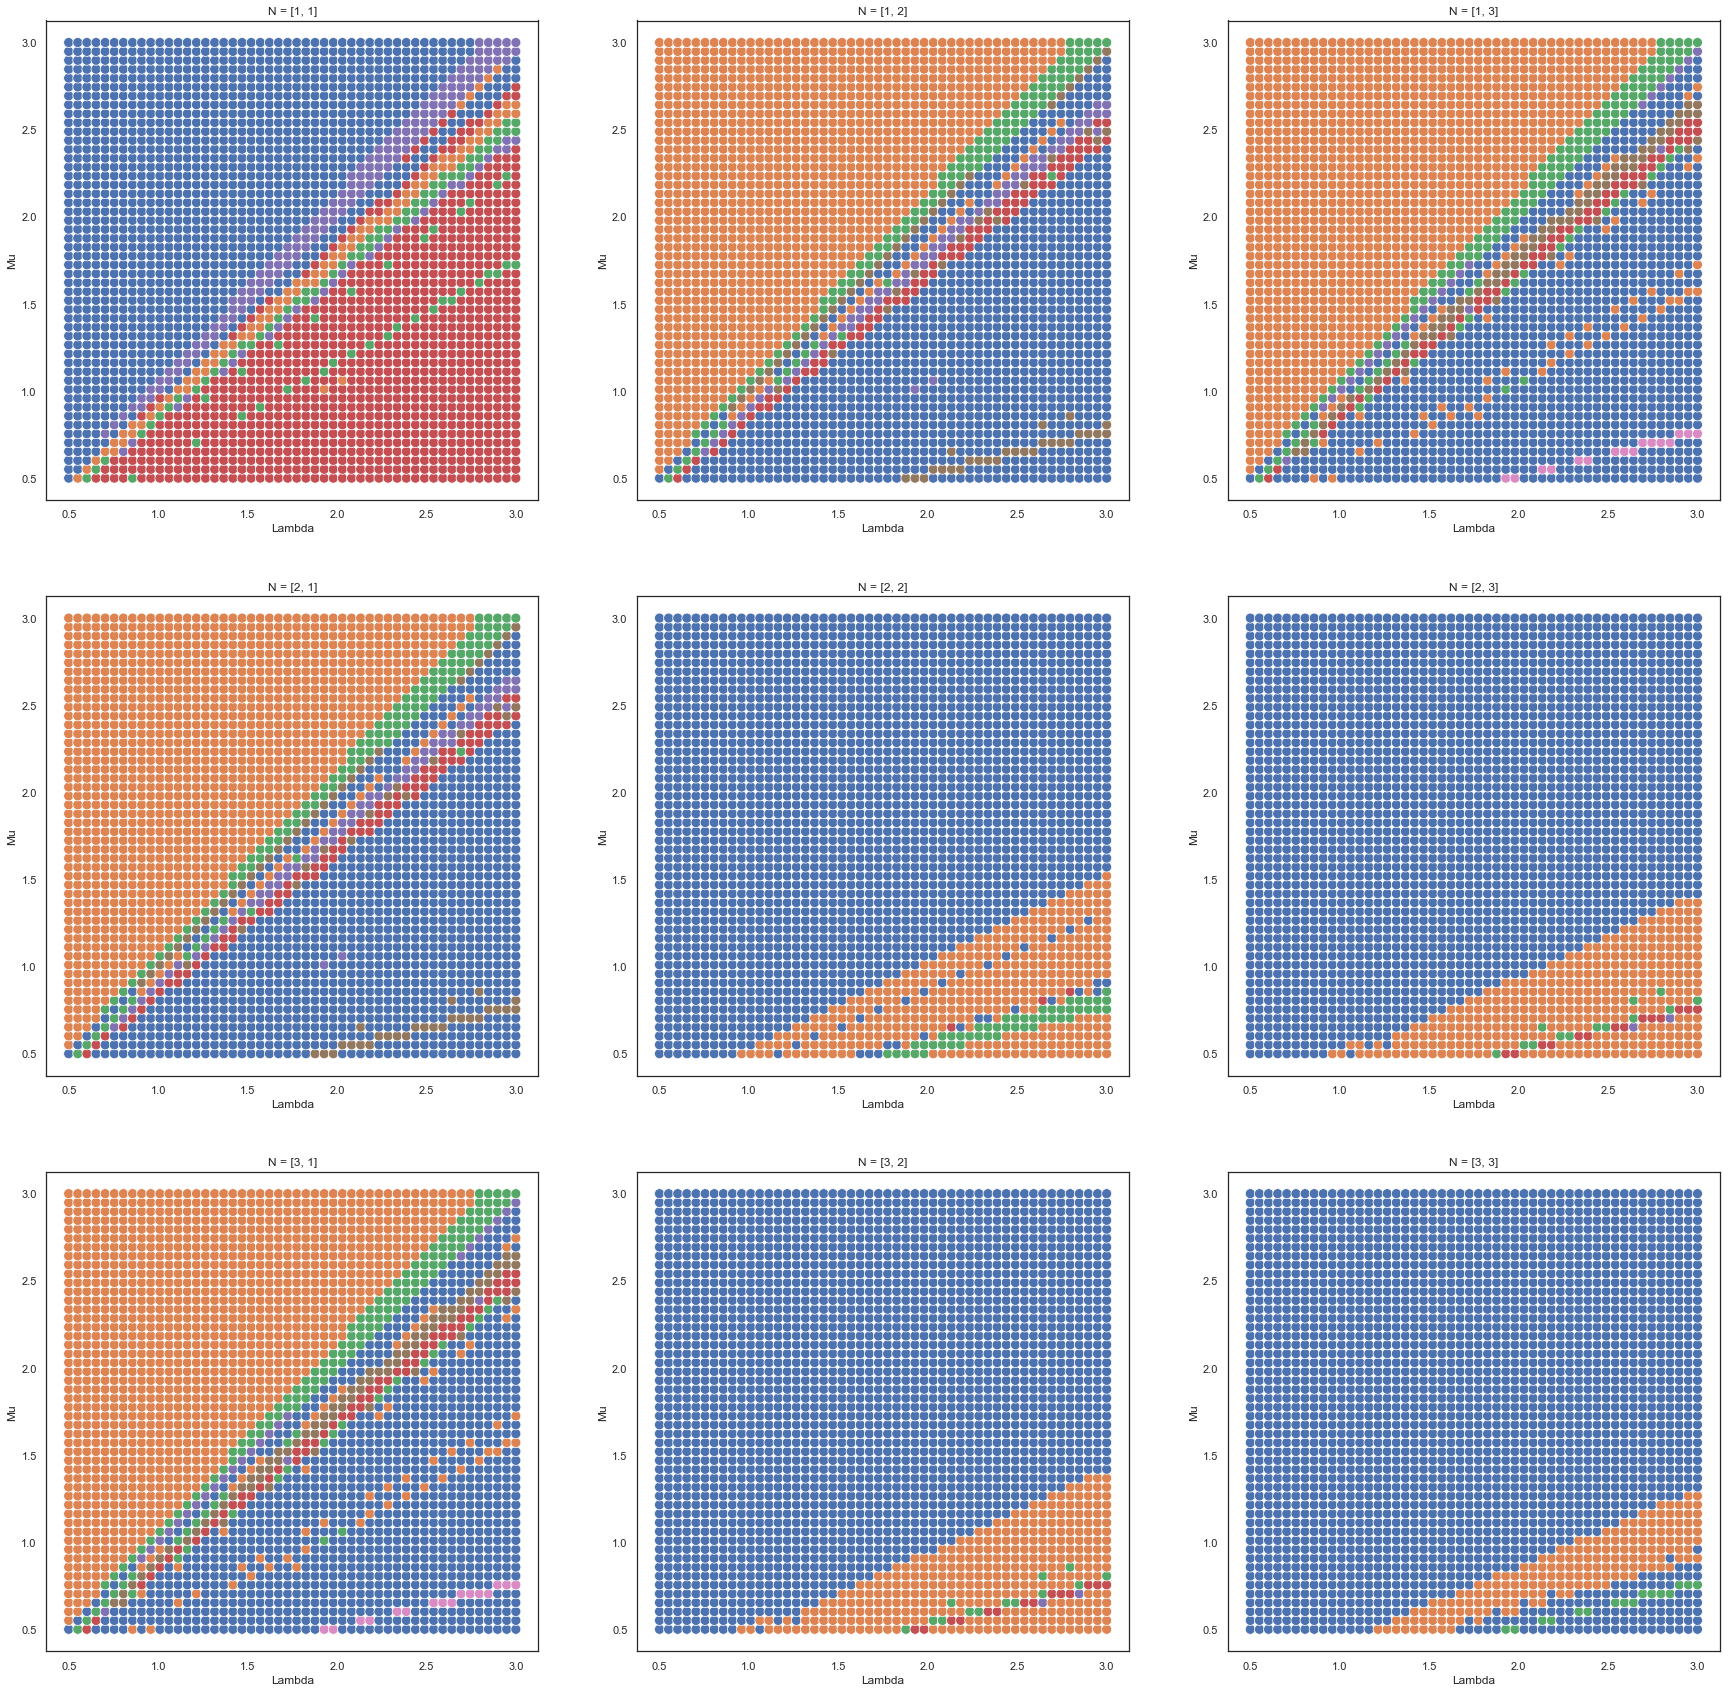

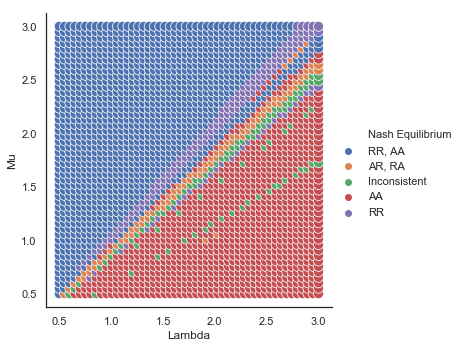

In [17]:
%%time
sns.set(style='white')
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(30, 30))
solution_plot([1,1], axs[0][0])
solution_plot([1,2], axs[0][1])
solution_plot([1,3], axs[0][2])
solution_plot([2,1], axs[1][0])
solution_plot([2,2], axs[1][1])
solution_plot([2,3], axs[1][2])
solution_plot([3,1], axs[2][0])
solution_plot([3,2], axs[2][1])
solution_plot([3,3], axs[2][2])
[plt.close(i) for i in range(2, 11)]
solution_plot([1,1], legend='brief')

In [19]:
def global_solution(l, mu, n):
    hospital = HospitalModel(l, mu, n, N_lim, t_c)
    G = hospital.global_average_time_matrix()
    solution = np.min(G)
    if solution < 0:
        return 'Inconsistent'
    if G[0][0] == solution:
        return 'AA'
    elif G[0][1] == solution:
        return 'AR'
    elif G[1][0] == solution:
        return 'RA'
    else:
        return 'RR'

In [21]:
%matplotlib inline

def global_solution_plot(n, ax=None):
    data = {
        'Lambda': [],
        'Mu': [],
        'Optimal Strategy': []
    }
    for l in np.linspace(0.5, 3, 50):
        for mu in np.linspace(0.5, 3, 50):
            data['Lambda'].append(l)
            data['Mu'].append(mu)
            data['Optimal Strategy'].append(global_solution(l, mu, n))
    data  = pd.DataFrame(data)
    sns.relplot(x='Lambda', y='Mu', hue='Optimal Strategy', data=data, ax=ax, s=50)
    if ax is not None:
        ax.set_title('N = ' + str(n))

d:\programmes\python\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


Wall time: 15.8 s


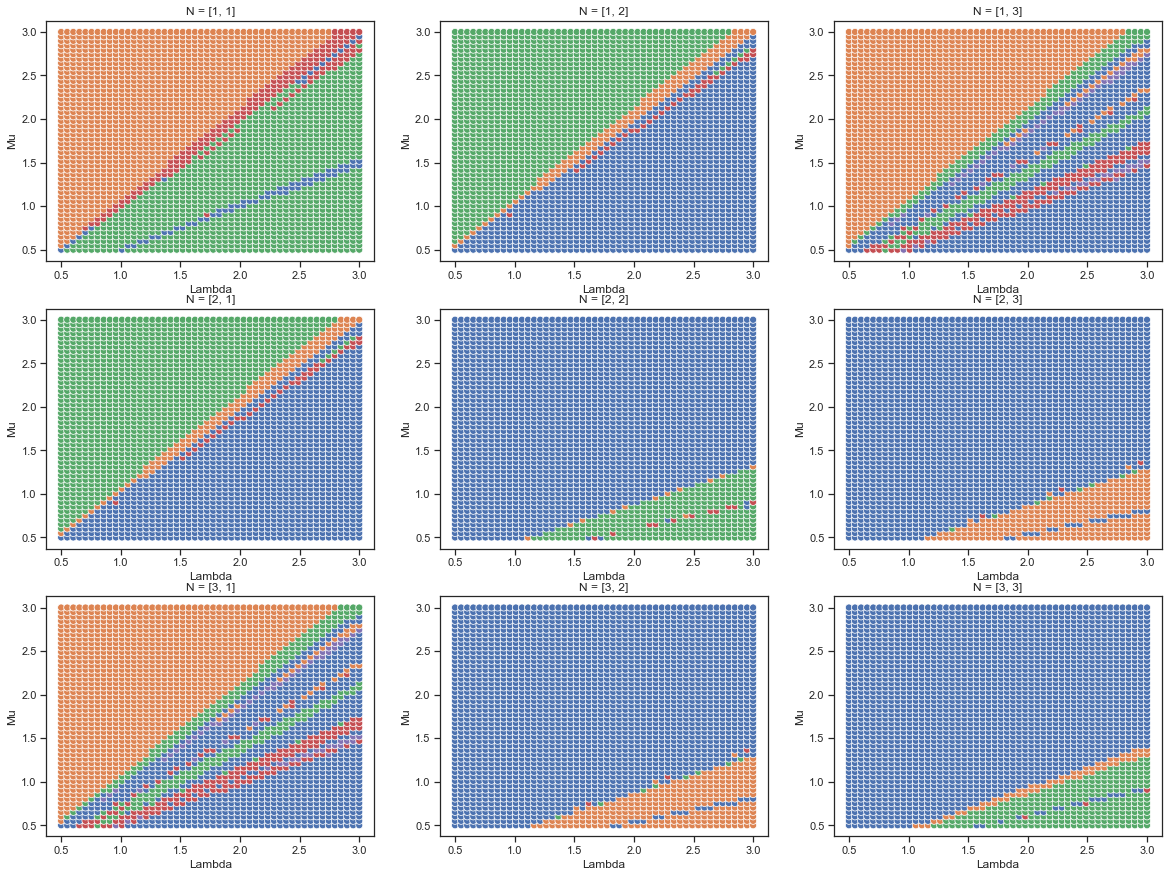

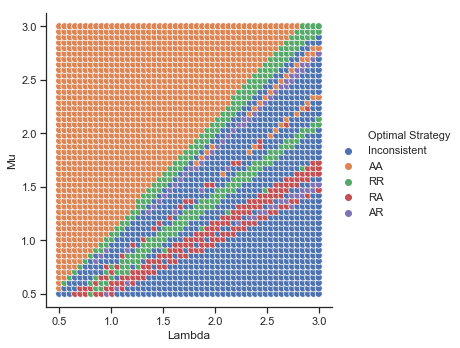

In [23]:
%%time
sns.set(style='ticks')
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 15))
global_solution_plot([1,1], axs[0][0])
global_solution_plot([1,2], axs[0][1])
global_solution_plot([1,3], axs[0][2])
global_solution_plot([2,1], axs[1][0])
global_solution_plot([2,2], axs[1][1])
global_solution_plot([2,3], axs[1][2])
global_solution_plot([3,1], axs[2][0])
global_solution_plot([3,2], axs[2][1])
global_solution_plot([3,3], axs[2][2])
[plt.close(i) for i in range(2, 11)]
global_solution_plot([1,3])

In [25]:
def global_plot(n, ax, mu=1, N_lim=5, t_c=10):
    data = {
        'Patients Inflow': [],
        'Global time': [],
        'Strategy': []
    }
    l_space = np.linspace(0.1, 0.8, 50)
    for l in l_space:
        hospital = HospitalModel(l, mu, n, N_lim, t_c)
        G = hospital.global_average_time_matrix()
        data['Patients Inflow'].append(l)
        data['Global time'].append(G[0][0])
        data['Strategy'].append('AA')
        
        data['Patients Inflow'].append(l)
        data['Global time'].append(G[0][1])
        data['Strategy'].append('AR')
        
        data['Patients Inflow'].append(l)
        data['Global time'].append(G[1][0])
        data['Strategy'].append('RA')
        
        data['Patients Inflow'].append(l)
        data['Global time'].append(G[1][1])
        data['Strategy'].append('RR')
    data = pd.DataFrame(data)
    sns.lineplot(x="Patients Inflow", y="Global time", hue="Strategy", data=data, ax=ax)
    ax.set_title('Server N = ' + str(n))

Wall time: 787 ms


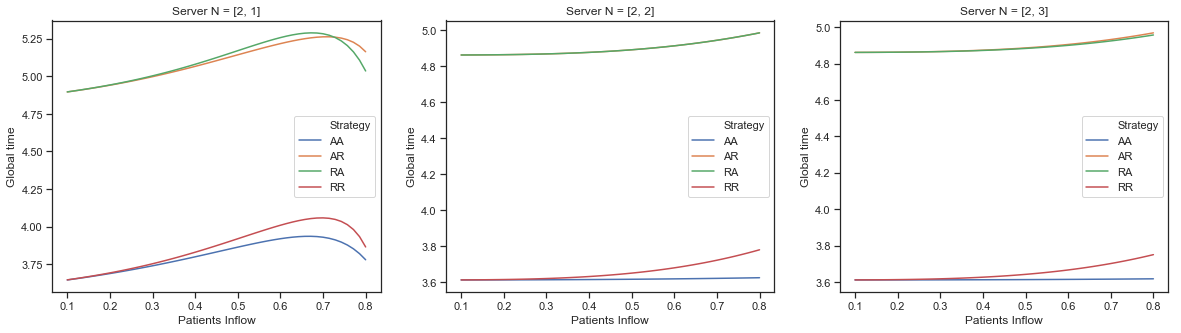

In [27]:
%%time
mu = 0.9
N_lim=3
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
global_plot([2,1], axs[0], mu=mu, N_lim=N_lim)
global_plot([2,2], axs[1], mu=mu, N_lim=N_lim)
global_plot([2,3], axs[2], mu=mu, N_lim=N_lim)

In [60]:
from numpy.random import uniform

class Point2D:
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def dist(self, point):
        return np.sqrt((self.x - point.x) ** 2 + (self.y - point.y) ** 2)
    
    def __repr__(self):
        return '(' +  str(self.x) + ';'  + str(self.y) + ')'
    
    @staticmethod
    def random_point_in_circle(r):
        x = uniform(-r, r)
        y2 = (r ** 2) - (x ** 2)
        y = np.sqrt(y2)
        if rand() > 0.5:
            y = -y
        return Point2D(x, y)


In [61]:
class Patient:
    def __init__(self, request_location, request_time, serve_time):
        self.request_location = request_location
        self.request_time = request_time
        self.serve_time = serve_time
        self.transp_time = None
        self.queue_time = None        
        self.arrival_time = None
        self.serve_start_time = None
        self.serve_finish_time = None
        self.fetch_strategy = None
        
    def __repr__(self):
        return 'Patient reqT=%d arrT=%d ssT=%d sfT=%d' % (self.request_time, self.arrival_time, 
                                                         self.serve_start_time, self.serve_finish_time)
    
    def set_transp_time(self, transp_time):
        self.transp_time = transp_time
        self.arrival_time = self.request_time + transp_time
    
    def set_queue_time(self, queue_time):
        self.queue_time = queue_time
        self.serve_start_time = self.arrival_time + queue_time
        self.serve_finish_time = self.serve_start_time + self.serve_time

In [62]:
class Event:
    def __init__(self, event_type, patient, time, queue=None, hospital=None):
        self.type = event_type
        self.patient = patient
        self.time = time
        self.queue = queue
        self.hospital = hospital

In [63]:
from numpy.random import exponential
from numpy.random import rand


class Stream:
    
    def __init__(self, l, mu, timesteps, r):
        self.l = l
        self.mu = mu
        self.timesteps = timesteps
        self.r = r
        self.events = []
        self.total_patients = 0
        self.generate()    
    
    def create_appear_event(self, time, serve_time):
        loc = Point2D.random_point_in_circle(self.r)
        return Event('appear', Patient(loc, time, serve_time), time)
    
    def generate(self):
        time = 0
        interval_distr = exponential(self.l, 2000)
        serve_distr = exponential(self.mu, 2001)
        self.interval_mean = np.mean(interval_distr)
        self.events.append(self.create_appear_event(time, serve_distr[0]))
        for interval, serve_time in zip(interval_distr, serve_distr[1:]):
            time += interval
            if time < self.timesteps:
                self.events.append(self.create_appear_event(time, serve_time)) 
            else:
                break
        self.total_patients = len(self.events)
    

In [64]:
a = Stream(25,50, 2000, 50)
print('Mean of interval between patient appearing:', a.interval_mean)
print('Total patients', a.total_patients)


Mean of interval between patient appearing: 25.056727991589614
Total patients 87


In [65]:
Point2D.random_point_in_circle(50)

(-7.987533613691241;-49.35786975518851)

In [66]:
from sortedcontainers import SortedList

class Queue:
    def __init__(self):
        self.queue = SortedList([], key=lambda patient: patient.arrival_time)
        self.served = 0
        self.load = [0]
        self.arrival_times = [0]
    
    def length(self, request_time):
        return sum([1 for patient in self.queue if patient.arrival_time <= request_time])
    
    def update_queue(self):
        if self.current_patient is not None and self.current_patient.serve_finish_time <= self.time:
            self.total_patients_served += 1
            self.current_patient = None
        if len(self.queue) > 0 and self.queue[0].serve_start_time <= self.time:
            self.current_patient = self.queue.pop(0)
        
    def add_patient(self, patient):
        self.queue.add(patient)
        self.load.append(self.load[-1] + 1)
        self.arrival_times.append(patient.arrival_time)

    def pop(self, patient):
        self.served += 1
        self.queue.pop(0)
        self.load.append(self.load[-1] - 1)
        self.arrival_times.append(patient.serve_finish_time)
                         
    def calc_expected_queue_time(self, requested_time):
        queue = [patient for patient in self.queue 
                 if patient.arrival_time <= requested_time and patient.serve_finish_time > requested_time]
        if not queue:
            return 0
        else:
            return queue[0].serve_finish_time - requested_time + sum(map(lambda p: p.serve_time, queue))

In [67]:
from math import ceil

class Hospital2D:
    def __init__(self, strategy, location, servers_number, queue_buffer, velocity):
        self.strategy = strategy
        self.location = location
        self.servers_number = servers_number
        self.velocity = velocity
        self.queue_buffer = queue_buffer
        self.served = 0
        self.appeared = 0
        self.servers_queue = [Queue() for _ in range(servers_number)]
        self.patients = []
    
    def can_accept_patient(self, time):
        if self.strategy == 'A':
            return True
        return self.find_shortest_queue(time).length(time) < self.queue_buffer
    
    def find_shortest_queue(self, time):
        return min(self.servers_queue, key=lambda queue: queue.length(time))
    
    def calc_queue_time(self, patient):
        return self.find_shortest_queue(patient.arrival_time).calc_expected_queue_time(patient.arrival_time)
    
    def expected_travel_and_queue_time(self, patient):
        patient.set_transp_time(self.calc_transp_time(patient))
        queue_time = self.find_shortest_queue(patient.arrival_time).calc_expected_queue_time(patient.arrival_time)
        return patient.transp_time + queue_time
                        
    def calc_transp_time(self, patient):
        return self.location.dist(patient.request_location) / self.velocity
    
            
    def add_patient(self, patient):
        patient.set_queue_time(self.calc_queue_time(patient))
        self.patients.append(patient)
        queue = self.find_shortest_queue(patient.arrival_time)
        queue.add_patient(patient)
        self.appeared += 1
        return queue

In [68]:
class Hospitals2DModel:
    def __init__(self, lambda_inflow, servers_in_hospital, strategies, mu=1, timesteps=2000, 
                 hosp_locations=[Point2D(-25, 25), Point2D(0, -43), Point2D(25, 25)], 
                 queue_buffer=10, r=50, velocity=2):
        self.hospitals = [Hospital2D(strategies[i], hosp_locations[i], servers_in_hospital[i], 
                                     queue_buffer, velocity) for i in range(len(hosp_locations))]
        self.stream = Stream(lambda_inflow, mu, timesteps, r)
        self.appeared = self.stream.total_patients
        self.mu = mu
        self.timesteps = timesteps
        self.queue_buffer = queue_buffer
        self.velocity = velocity 
        self.served = 0
        self.patients = []
        self.events = SortedList(self.stream.events, key=lambda event: event.time)
        self.model_queue()
        
    def __repr__(self):
        return str((self.appeared, self.served)) 
    
    def sorted_by_transp_time(self, patient):
        return sorted(self.hospitals, key=lambda hosp: hosp.calc_transp_time(patient))
    
    def min_by_expected_travel_and_queue_time(self, patient):
        return min(self.hospitals, key=lambda hosp: hosp.expected_travel_and_queue_time(patient))

    
    def distribute_patient(self, patient):
        self.patients.append(patient)
        for hosp, i in zip(self.sorted_by_transp_time(patient), range(len(self.hospitals))):
            patient.set_transp_time(hosp.calc_transp_time(patient))
            if hosp.can_accept_patient(patient.arrival_time):
                queue = hosp.add_patient(patient)
                # print(patient)
                self.events.add(Event('served', patient, patient.serve_finish_time, queue, hosp))
                patient.fetch_strategy = 'Closest Dist ' + str(i + 1)
                return
        best_hosp = self.min_by_expected_travel_and_queue_time(patient)
        patient.fetch_strategy = 'Best expected time'
        queue = best_hosp.add_patient(patient)
        self.events.add(Event('served', patient, patient.serve_finish_time, queue, hosp))
    
    def model_queue(self):
        while self.events:
            event = self.events.pop(0)
            if event.time > self.timesteps:
                break
            if event.type == 'appear':
                self.distribute_patient(event.patient)
            elif event.type == 'served':
                event.queue.pop(event.patient)
                self.served += 1
                event.hospital.served += 1
        return self.appeared, self.served
    
    def show_patients(self, fromIndex=0, untilIndex=None):
        patients = self.patients[fromIndex:untilIndex]
        for patient in patients:
            print(patient)
                

Hospitals2DModel(lambda_inflow, servers_in_hospital, strategies, timesteps=2000, 
                 hosp_locations=[Point2D(-25, 25), Point2D(0, -43), Point2D(25, 25)], 
                 queue_buffer=10, r=50, velocity=2)

In [51]:
model = Hospitals2DModel(25, [2,1, 1], 'RAR', mu=50)
model.show_patients(-5)

Patient reqT=1909 arrT=1913 ssT=2118 sfT=2130
Patient reqT=1911 arrT=1920 ssT=2084 sfT=2135
Patient reqT=1952 arrT=1956 ssT=2130 sfT=2154
Patient reqT=1993 arrT=2002 ssT=2166 sfT=2206
Patient reqT=1997 arrT=2005 ssT=2005 sfT=2153


In [69]:
class HospitalStats:
    def __init__(self, appeared, served, patients):
        self.appeared = appeared
        self.served = served
        self.patients = patients
        
    def __repr__(self):
        return 'HospitalStats: {\n' + \
               '    appeared=' + str(self.appeared) + '\n' + \
               '    served=' + str(self.served) + '\n' \
               + '}'


class SimulationStats:
    def __init__(self, l, servers, strategies, mu=100, queue_buffer=5, hospitals_count=3):
        self.l = l
        self.servers = servers
        self.strategies = strategies
        self.mu = mu
        self.queue_buffer = queue_buffer
        self.hospitals_count = hospitals_count
        self.mean_of_simmulations()

    def __repr__(self):
        return 'SimulationStats: {' + \
               '\nappeared=' + str(self.appeared) + \
               '\nserved=' + str(self.served) + \
               '\nhospitals=' + str(self.hospitals) + \
               '\n}'

    def column(self, arr, i):
        return [row[i] for row in arr]

    def aggregate_patient(self, patient_simulations):
        serve_time = np.mean([patient.serve_time for patient in patient_simulations])
        queue_time = np.mean([patient.queue_time for patient in patient_simulations])
        transp_time = np.mean([patient.transp_time for patient in patient_simulations])
        patient = Patient(None, None, serve_time)
        patient.transp_time = transp_time
        patient.queue_time = queue_time
        return patient

    def aggregate_patients(self, patients_simulations):
        # print(len(list(patients_simulations)))
        if not patients_simulations[0]:
            return []
        patients_count = np.min([len(patients_simulation) for patients_simulation in patients_simulations])
        return [self.aggregate_patient(self.column(patients_simulations, i)) for i in range(patients_count)]

    def aggregate_hospital(self, hospital_simulations):
        appeared = np.mean([hospital.appeared for hospital in hospital_simulations])
        served = np.mean([hospital.served for hospital in hospital_simulations])
        patients = self.aggregate_patients([hospital.patients for hospital in hospital_simulations])
        return HospitalStats(appeared, served, patients)

    def aggregate_hospitals(self, hospitals_simulations):
        return [self.aggregate_hospital(self.column(hospitals_simulations, i)) for i in range(self.hospitals_count)]

    def mean_of_simmulations(self):
        patients = []
        appeared = []
        served = []
        hospitals = []
        for i in range(10):
            model = Hospitals2DModel(self.l, self.servers, self.strategies, mu=self.mu,
                                     queue_buffer=self.queue_buffer)
            patients.append(model.patients)
            appeared.append(model.appeared)
            served.append(model.served)
            hospitals.append(model.hospitals)
        self.appeared = np.mean(appeared)
        self.served = np.mean(served)
        self.patients = self.aggregate_patients(patients)
        self.hospitals = self.aggregate_hospitals(hospitals)

class HospitalStats:
    def __init__(self, appeared, served, patients):
    
class SimulationStats:
    def __init__(self, l, servers, strategies, mu=100, queue_buffer=5, hospitals_count=3):

In [70]:
print(SimulationStats(25, [2,3,4], 'RRR'))

SimulationStats: {
appeared=80.6
served=67.5
hospitals=[HospitalStats: {
    appeared=22.5
    served=18.2
}, HospitalStats: {
    appeared=37.0
    served=30.1
}, HospitalStats: {
    appeared=21.1
    served=19.2
}]
}


In [71]:
def served_and_appeared_patients_plot(n, ax, mu=50, queue_buffer=5):
        data = {
            'The number of patients appeared': [],
            'The number of patients served in system': [],
            'Strategy': []
        }
        l_space = np.linspace(6, 40, 30)
        strategies = ['AAA', 'ARA', 'AAR', 'ARR', 'RAA', 'RRA', 'RAR', 'RRR']
        #strategies = ['AAA', 'RRR']
        for strategy in strategies:
            for lambda_inflow in l_space:
                stats = SimulationStats(lambda_inflow, n, strategy, mu=mu, queue_buffer=queue_buffer)
                appeared, served = stats.appeared, stats.served 
                data['The number of patients appeared'].append(appeared)
                data['The number of patients served in system'].append(served)
                data['Strategy'].append(strategy)

        data = pd.DataFrame(data)
        sns.lineplot(x="The number of patients appeared", y='The number of patients served in system',
                         hue="Strategy", data=data, ax=ax, palette='bright')
        ax.set_title('Server N = ' + str(n))
        [ax.lines[i].set_linestyle("--") for i in range(len(strategies))]

In [72]:
def record_for_each_patient_global(ax, strategy, mu, l=25, ylim=None, queue_buffer=5):
    data = {
        'Transporation time': [],
        'Serving time': [],
        'Queuing time': [],
        'Patient id': []
        
    }
    stats = SimulationStats(l, [2,3,4], strategy, mu=mu)
    for patient, id in zip(stats.patients, range(len(stats.patients))):
        data['Transporation time'].append(patient.transp_time)
        data['Serving time'].append(patient.serve_time)
        data['Queuing time'].append(patient.queue_time)
        data['Patient id'].append(id)
    data = pd.DataFrame(data)
    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    ax.set_title('Time record for each patient in system with strategy ' + strategy)
    print(data.tail(10))
    sns.barplot(x="Patient id", y='Transporation time',
                     label="Transporation time", data=data, ax=ax, color='b')
    sns.barplot(x="Patient id", y='Serving time', color='g', label='Serving time', data=data, ax=ax)
    sns.set_color_codes('muted')
    sns.barplot(x="Patient id", y='Queuing time', color='r', label='Queuing time', data=data, ax=ax)
    
    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="upper right", frameon=True)
    ax.set( xlim=(0, 50), ylabel="", ylim=ylim, xlabel="Patient id")
    sns.despine(left=True, bottom=True)

In [73]:
_, ax = plt.subplots(figsize=(10, 5))
%%time
([2,3,4], ax, mu=80, queue_buffer=3)
served_and_appeared_patients_plot


SyntaxError: invalid syntax (<ipython-input-73-31b73b631705>, line 2)

     Transporation time  Serving time  Queuing time  Patient id
178            9.704863     62.835289    882.174166         178
179            9.939273    107.678695   1016.052483         179
180           11.539924    105.068503    920.728391         180
181           10.836237    105.821004    779.338935         181
182           12.796055     87.054805   1053.791874         182
183           11.775678     72.873191    998.294494         183
184           10.891022    115.561254    817.242917         184
185            8.672430     88.881299    690.290488         185
186           13.616941     85.400274    561.659276         186
187           11.513752     74.580064   1179.909896         187
     Transporation time  Serving time  Queuing time  Patient id
155           26.127706     86.980747    410.629674         155
156           26.117006     77.460121    527.074622         156
157           19.295321     83.434266    586.758036         157
158           19.509808    114.651265   

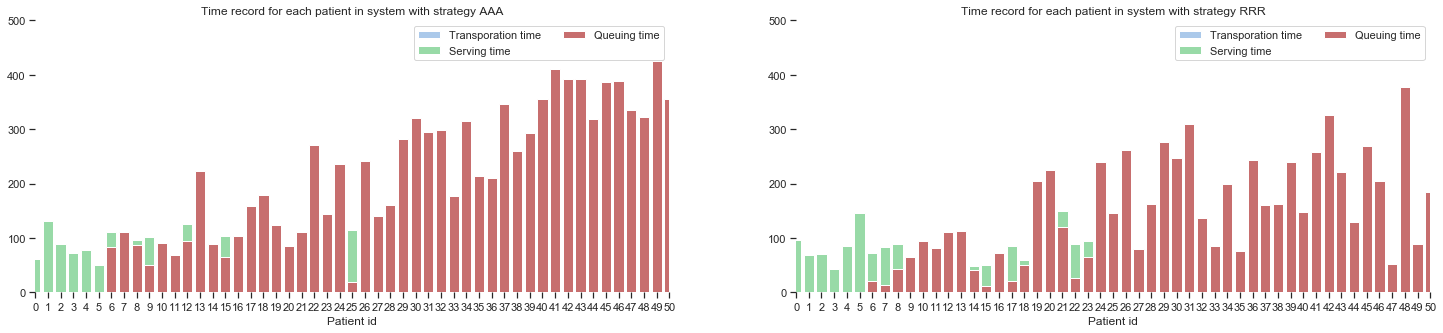

In [ ]:
%%time
l = 10
mu = 80
queue_buffer=3
ylim = (0, 500)
_, axs = plt.subplots(ncols=2, figsize=(25, 5))
record_for_each_patient_global(axs[0], 'AAA', mu, ylim=ylim, queue_buffer=queue_buffer, l=l)
record_for_each_patient_global(axs[1], 'RRR', mu, ylim=ylim, queue_buffer=queue_buffer, l=l)

In [ ]:
def record_for_each_patient(hosp_num, stats, ax, servers, strategy, ylim=None, xlim=None):
    data = {
        'Transporation time': [],
        'Serving time': [],
        'Queuing time': [],
        'Patient id': []
        
    }
    for patient, id in zip(stats.hospitals[hosp_num].patients, range(len(stats.hospitals[hosp_num].patients))):
        data['Transporation time'].append(patient.transp_time)
        data['Serving time'].append(patient.serve_time)
        data['Queuing time'].append(patient.queue_time)
        data['Patient id'].append(id)
    data = pd.DataFrame(data)
    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    ax.set_title('Time record in H%d[server=%d] with strategy %s' % (hosp_num, servers[hosp_num], strategy))
    sns.barplot(x="Patient id", y='Transporation time',
                     label="Transporation time", data=data, ax=ax, color='b')
    sns.barplot(x="Patient id", y='Serving time', color='g', label='Serving time', data=data, ax=ax)
    sns.set_color_codes('muted')
    sns.barplot(x="Patient id", y='Queuing time', color='r', label='Queuing time', data=data, ax=ax)
    
    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="upper right", frameon=True)
    ax.set(xlim=xlim, ylabel="", ylim=ylim, xlabel="Patient id")
    sns.despine(left=True, bottom=True)

Wall time: 3.85 s


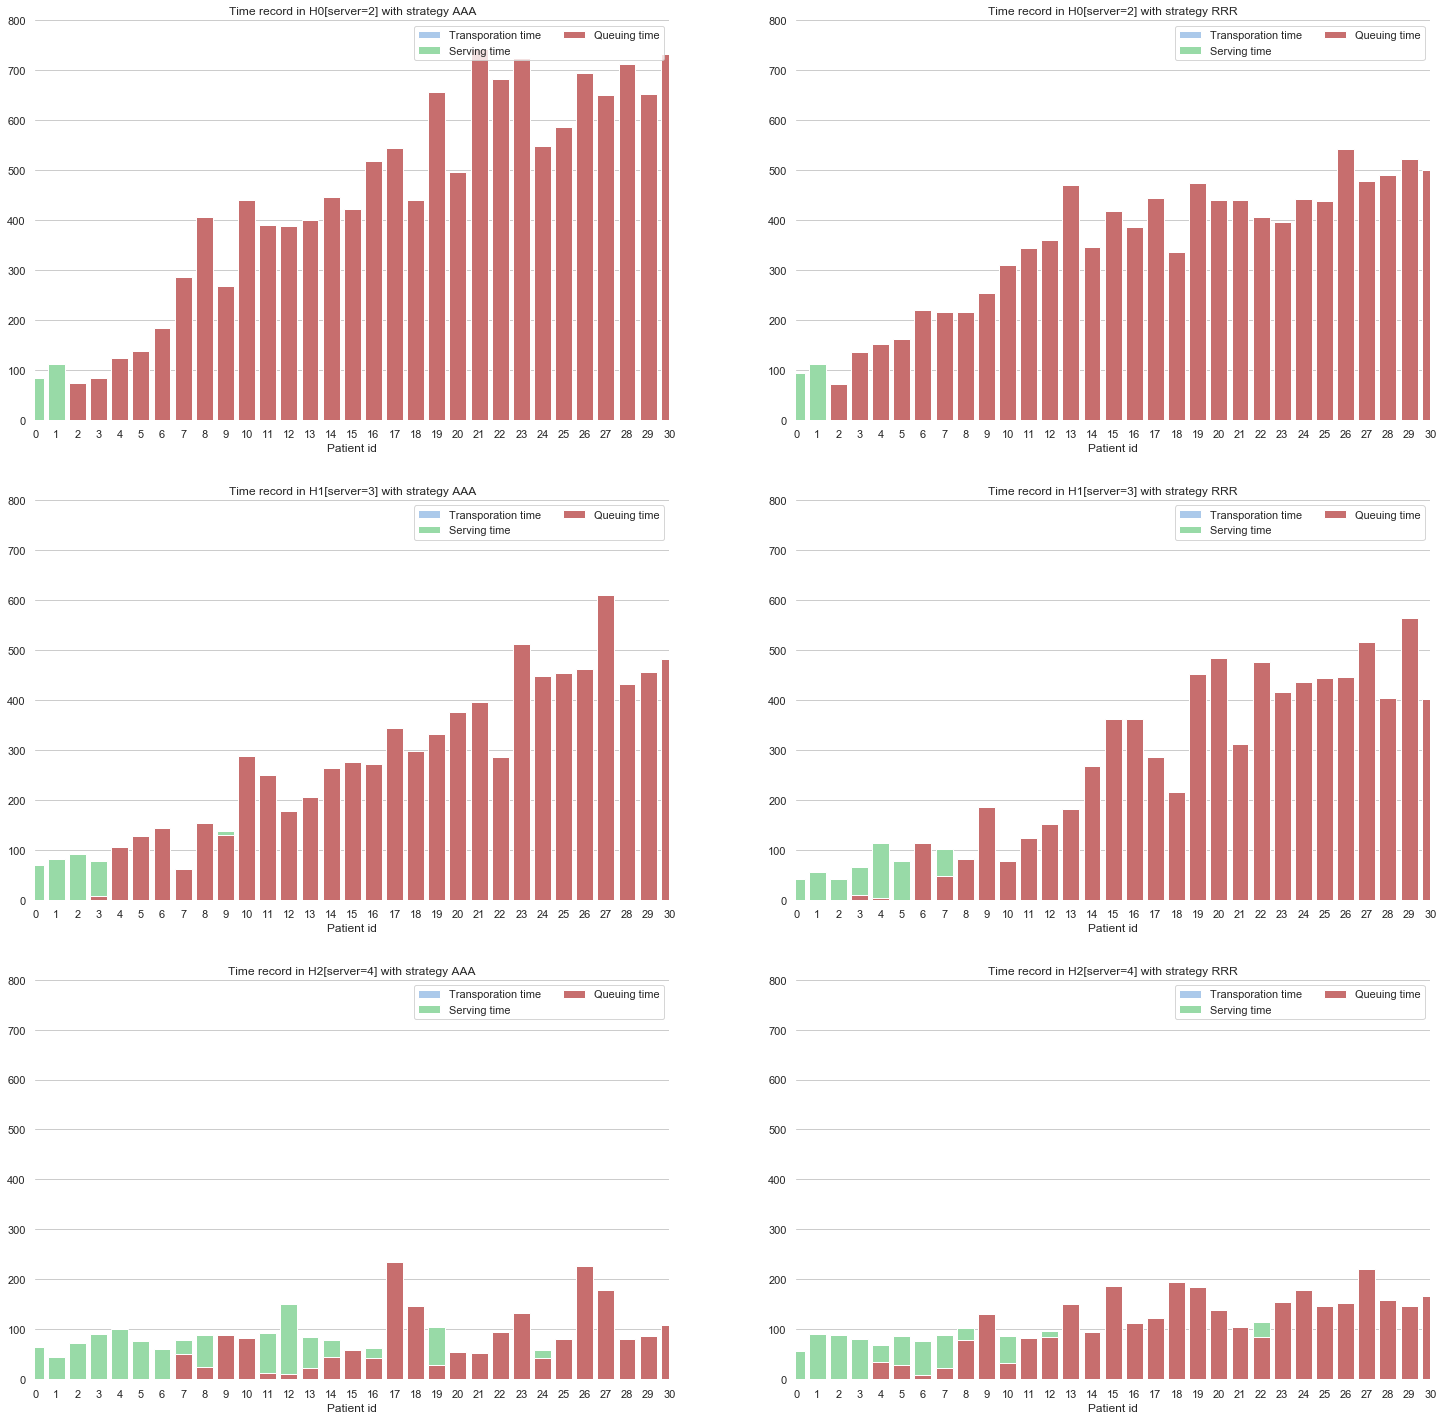

In [ ]:
%%time
mu = 80
queue_buffer=5
ylim = (0, 800)
xlim = (0, 30)
l = 10
servers = [2,3,4]
aaa_stats = SimulationStats(l, [2,3,4], 'AAA', mu=mu, queue_buffer=queue_buffer)
rrr_stats = SimulationStats(l, [2,3,4], 'RRR', mu=mu, queue_buffer=queue_buffer)
_, axs = plt.subplots(ncols=2, nrows=3, figsize=(25, 25))
for i in range(3):
    record_for_each_patient(i, aaa_stats, axs[i][0], servers, 'AAA', ylim, xlim)
    record_for_each_patient(i, rrr_stats, axs[i][1], servers, 'RRR', ylim, xlim)

In [ ]:
def fetch_strategy_stats(strategy='RRR', mu=150, ax=None, hosp_num=None):
    model = Hospitals2DModel(4, [2,3,4], strategy, mu=mu)
    freq = {}
    patients = model.patients if hosp_num == None else model.hospitals[hosp_num].patients
    for patient in patients:
        if patient.fetch_strategy not in freq:
            freq[patient.fetch_strategy] = 0
        freq[patient.fetch_strategy] += 1
    data = {
        'Strategy': [],
        'Frequency':[]
    }
    for strategy, count in freq.items():
        data['Strategy'].append(strategy)
        data['Frequency'].append(count)
    data = pd.DataFrame(data)
    sns.barplot(x="Strategy", y='Frequency', label='Strategy frequency', data=data, ax=ax)
    if ax is not None:
        ax.set_title('Global' if hosp_num == None else ('Hospital ' + str(hosp_num + 1)))

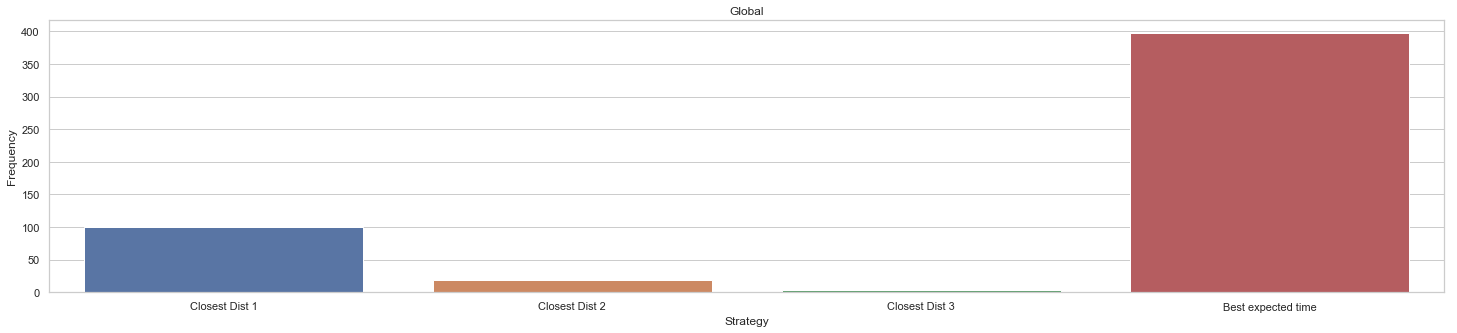

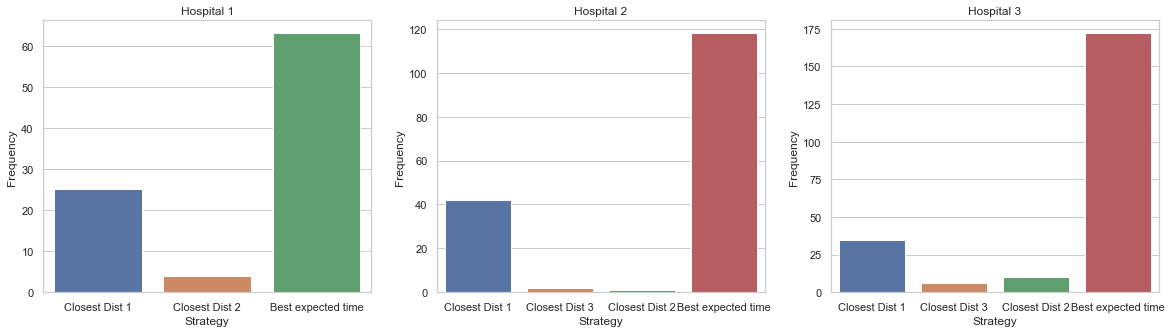

In [ ]:
_, ax = plt.subplots(figsize=(25,5))
fetch_strategy_stats('RRR', ax=ax)
_, axs = plt.subplots(ncols=3, figsize=(20, 5))
fetch_strategy_stats('RRR', ax=axs[0], hosp_num=0)
fetch_strategy_stats('RRR', ax=axs[1], hosp_num=1)
fetch_strategy_stats('RRR', ax=axs[2], hosp_num=2)

In [ ]:
def queue_plot(queue, hosp_num, queue_num, strategy, ax, ylim=None, queue_buffer=5):
    data = {
        'Time': queue.arrival_times + [0, 2000],
        'Load': queue.load + ([queue_buffer] * 2),
        'Type': ['Queue load' for _ in range(len(queue.arrival_times))] + (['Queue buffer'] * 2)
    }
    data = pd.DataFrame(data)
    sns.lineplot(x='Time', y='Load', hue='Type', data=data, ax=ax)
    ax.set_title('Queue load in Hospital {}, Server {} Strategy {}'.format(hosp_num + 1, queue_num + 1, strategy))
    ax.set(ylim=ylim)

Wall time: 1.8 s


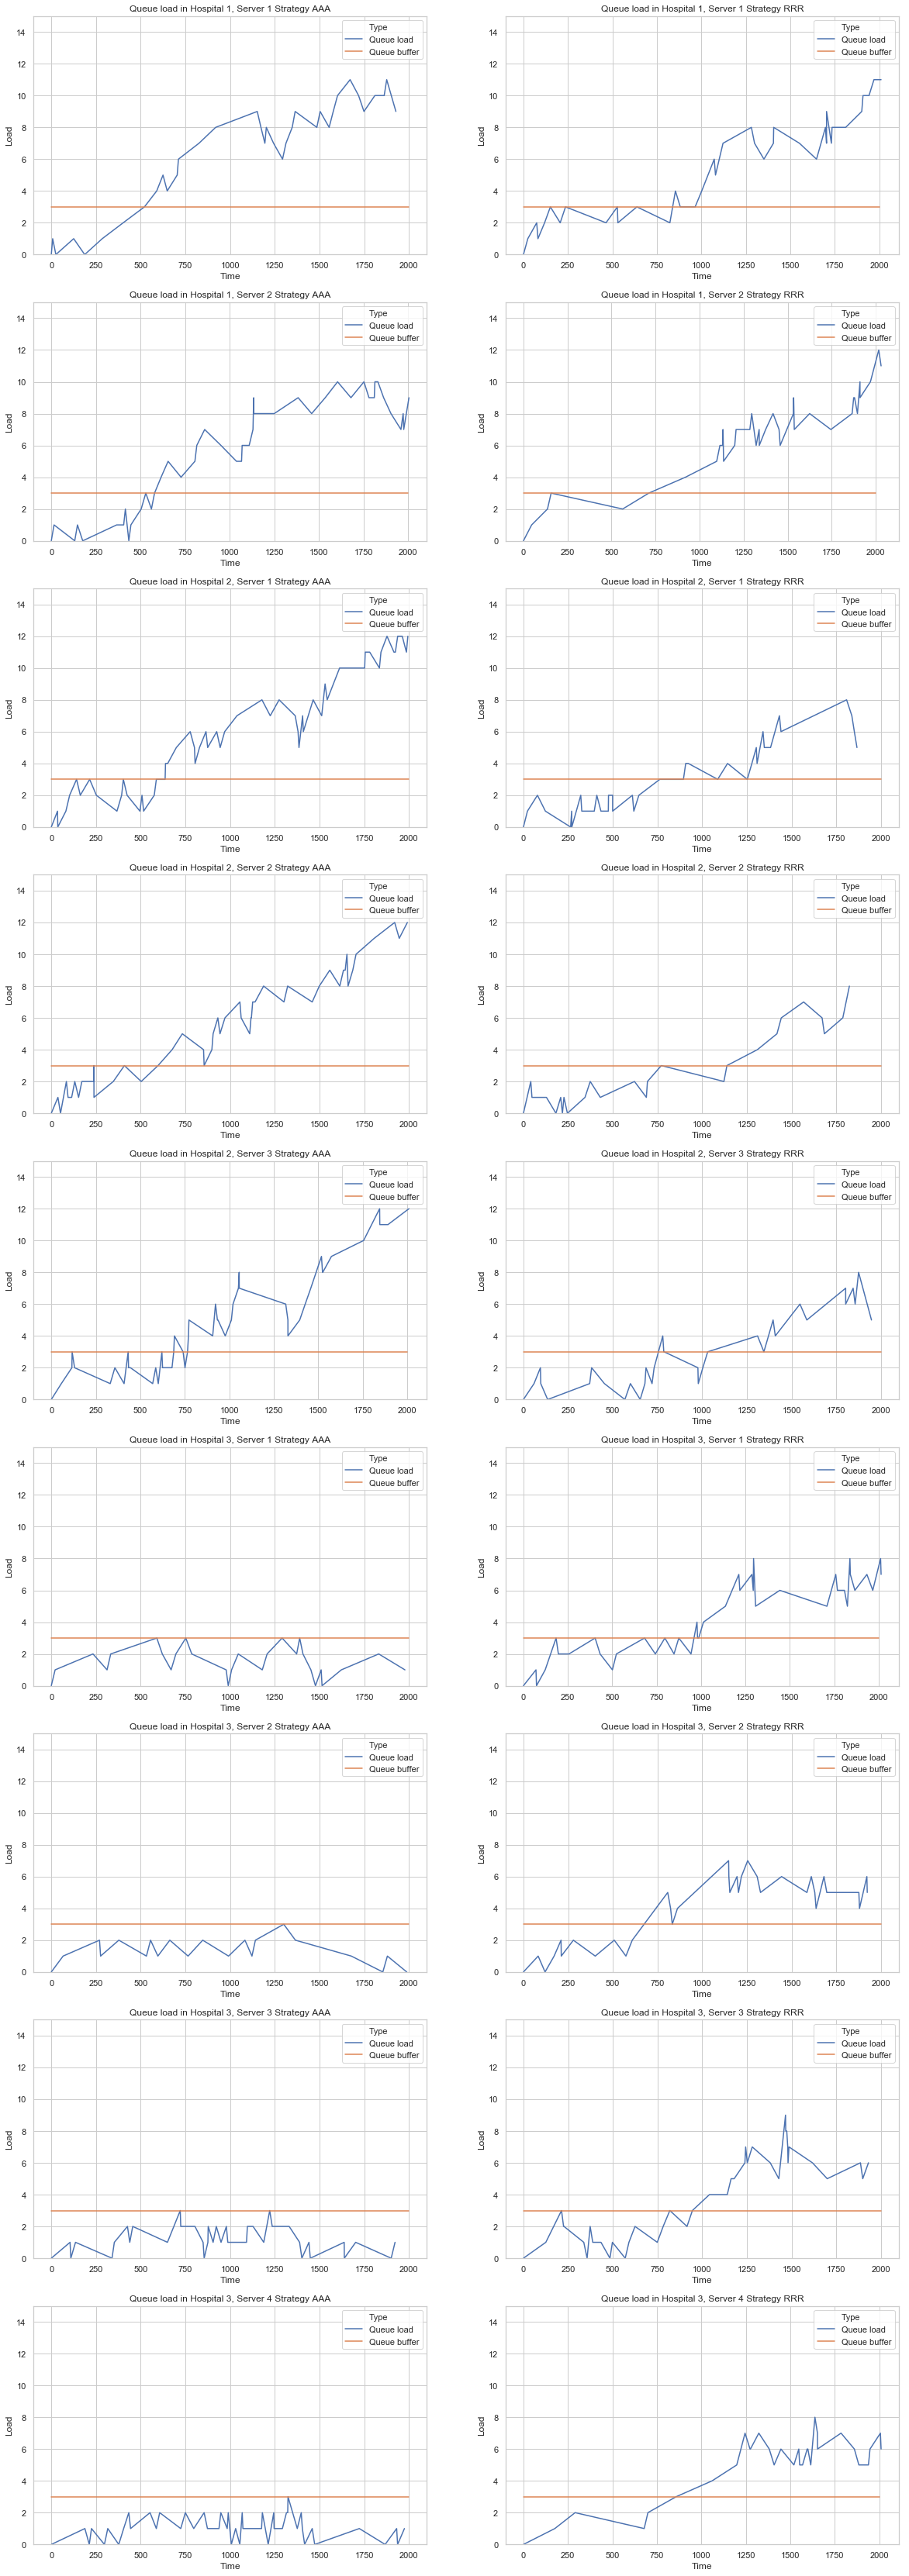

In [ ]:
%%time
l = 10
mu = 80
queue_buffer = 3
ylim = (0, 15)
aaa_model = Hospitals2DModel(l, [2,3,4], 'AAA', mu=mu, queue_buffer=queue_buffer)
rrr_model = Hospitals2DModel(l, [2,3,4], 'RRR', mu=mu, queue_buffer=queue_buffer)
_, axs = plt.subplots(ncols=2, nrows=9, figsize=(20, 60))
ax_index = 0
for i in range(len(model.hospitals)):
    for j in range(len(aaa_model.hospitals[i].servers_queue)):
        aaa_queue = aaa_model.hospitals[i].servers_queue[j]
        queue_plot(aaa_queue, i, j, 'AAA', axs[ax_index][0], ylim, queue_buffer=queue_buffer)
        rrr_queue = rrr_model.hospitals[i].servers_queue[j]
        queue_plot(rrr_queue, i, j, 'RRR', axs[ax_index][1], ylim, queue_buffer=queue_buffer)
        ax_index += 1